# 3. ベイズ推論の基礎

In [10]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## 3.3 ベイズ線形回帰

参考：https://leck-tech.com/machine-learning/bayesian-regression#i-5

まずモデルを作ってみる．
とりあえず，基底関数（特徴量関数）を定義する．
ここでは，**多項式基底関数**を用意する．

#### 多項式基底関数

In [33]:
def base_polynomial(x, M=2):
    """
    多項式基底を元にした特徴量関数の作成
    inputs:
        x : 2d-array. N*D  = (サンプル数)x(入力次元)
        M : 次数-1
    return:
        phi : 2d-array. N*((M+1)*D). (1つの特徴量に対してM次の基底関数を適用)
    """
    N = x.shape[0] # サンプル数
    D = x.shape[1] # 入力次元
    phi = np.zeros(shape=(N, int((M+1)*D)), dtype='float')
    for m in range(M+1):
        phi[:,m::(M+1)] = x**m
        # 各入力次元に対してm次の特徴量を計算
    return phi

In [89]:
x = np.array(3.)
x = x.reshape(-1,1)

In [90]:
phi = base_polynomial(x,3)

#### 事前分布からのサンプル

事前分布からのサンプルを見るため，簡潔にモデルを書いてみる．

In [201]:
def sample_from_prior(x, M=3, base_mode='polynomial', sigma_y=0.1):
    
    N = x.shape[0] # サンプル数
    D = x.shape[1] # 入力次元
    H = (M+1)*D
    
    # -- 事前分布のパラメータを設定-- 
    mu_0 = np.zeros(H)
    Sigma_0 = np.identity(H)
    
    # -- 事前分布から重みをサンプルする． --
    w = np.random.multivariate_normal(mean=mu_0, cov=Sigma_0)
    
    # 特徴量関数を計算
    if(base_mode == 'polynomial'):
        phi = base_polynomial(x, 3)
        
    # -- 事前分布からサンプリング --
    model_mean = np.einsum('h,nh->n', w, phi)
    
    return model_mean

事前分布からのサンプルをプロットする．これにより，データを観測する以前に候補となる関数を得ることができる．

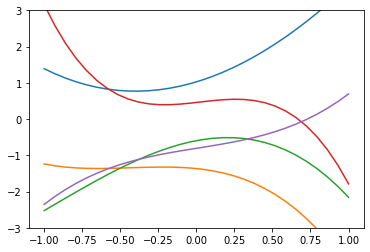

In [202]:
N = 30
x = np.linspace(-1, 1, N).reshape(-1,1)

for i in range(5):
    y = sample_from_prior(x)
    plt.plot(x,y)
plt.ylim(-3,3)
plt.show()
    

#### 事前分布だけを用いた予測分布の導出

場合によっては，学習を行う前に，事前分布だけを用いて何かしらの予測を行いたいこともあるかもしれない．

In [222]:
def predictive_distribution_using_prior(x, M=3, base_mode='polynomial', sigma_y=0.1):
    
    N = x.shape[0] # サンプル数
    D = x.shape[1] # 入力次元
    H = (M+1)*D
    
    # 事前分布のパラメータを設定
    mu_0 = np.zeros(H)
    Sigma_0 = np.identity(H)
    
    # 特徴量関数を計算
    if(base_mode == 'polynomial'):
        phi = base_polynomial(x, 3)
    
    mu = np.einsum('h,nh->n', mu_0, phi)
    sigma = sigma_y + np.einsum('nh,hh,nh->n',phi,Sigma_0,phi)
    
    return mu,sigma

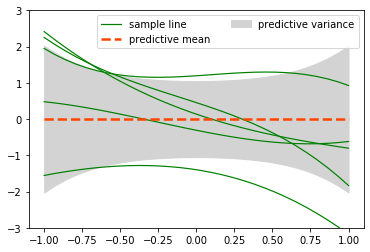

In [275]:
N = 30
x = np.linspace(-1, 1, N).reshape(-1,1)

for i in range(5):
    y = sample_from_prior(x)
    if i==0:
        plt.plot(x,y, color='green', linewidth = 1.2, label='sample line')
    else:
        plt.plot(x,y, color='green', linewidth = 1.2)
    
pred_mean, pred_var = predictive_distribution_using_prior(x)
upper = pred_mean + np.sqrt(pred_var)
lower = pred_mean - np.sqrt(pred_var)


plt.plot(x, pred_mean,color='orangered', linewidth = 2.5, linestyle='dashed', label='predictive mean')
plt.fill_between(x[:,0], upper, lower, color='lightgrey', label='predictive variance')
plt.legend(ncol=2)
plt.ylim(-3,3)
plt.show()

見てわかる通り，事前分布で仮定した構造（平均ゼロ，分散1）に基づき予測分布を導出できていることが分かる．
このように，ベイズ推論の枠組みではデータを学習していない段階でも何かしらの予測を行うことができる．
例えば，事前分布に対してもう少し具体的な事前情報（）を与えることで，その事前情報を最大限に利用した予測が可能である．

#### 学習と予測

実際に，データを学習させて予測を実装してみる．

In [975]:
def get_posterior_distribution(x, y, mu_0, Sigma_0, M=3, base_mode='polynomial', sigma_y=1):
    
    N = x.shape[0] # サンプル数
    D = x.shape[1] # 入力次元
    H = (M+1)*D
    
    # 特徴量関数を計算
    if(base_mode == 'polynomial'):
        phi = base_polynomial(x, 3)
    
    Sigma = np.linalg.inv((sigma_y**(-1))*np.dot(phi.T, phi) + np.linalg.inv(Sigma_0))
    mu = np.dot(Sigma, sigma_y**(-1)*np.sum(y*phi, axis=0))
    
    return mu, Sigma

In [976]:
def sample_from_posterior(x, mu, Sigma, M=3, base_mode='polynomial', sigma_y=1):
    
    N = x.shape[0] # サンプル数
    D = x.shape[1] # 入力次元
    H = (M+1)*D
    
    # -- 事前分布から重みをサンプルする． --
    w = np.random.multivariate_normal(mean=mu, cov=Sigma)
    
    # 特徴量関数を計算
    if(base_mode == 'polynomial'):
        phi = base_polynomial(x, 3)
        
    # -- 事前分布からサンプリング --
    model_mean = np.einsum('h,nh->n', w, phi)
    
    return model_mean

In [977]:
def predictive_distribution(x, mu, Sigma, M=3, base_mode='polynomial', sigma_y=1):
    
    N = x.shape[0] # サンプル数
    D = x.shape[1] # 入力次元
    H = (M+1)*D
    
    # 特徴量関数を計算
    if(base_mode == 'polynomial'):
        phi = base_polynomial(x, 3)
    
    mu_pred = np.dot(mu, phi.T)
    sigma_pred = sigma_y + np.diag(np.dot(phi.dot(Sigma), phi.T))
    
    return mu_pred,sigma_pred

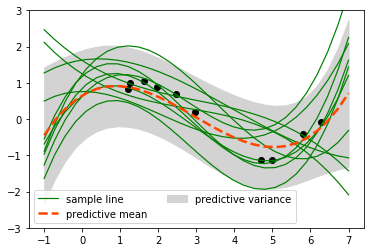

In [979]:
# 学習データ生成
#x_train = np.linspace(0, 6, 10).reshape(-1,1)
N_train = 10
x_train = 2*np.pi*np.random.rand(N_train).reshape(-1,1)
loc = 0
scale = 0.1
#y_train =  np.sin(2*np.pi*x_train) + np.random.normal(loc,scale,10).reshape(-1,1)
y_train =  np.sin(x_train) + np.random.normal(loc,scale,N_train).reshape(-1,1)

N = x_train.shape[0] # サンプル数
D = x_train.shape[1] # 入力次元
M = 3
H = (M+1)*D

mu_0 = np.zeros(H)
Sigma_0 = np.identity(H)

post_mu, post_Sigma = get_posterior_distribution(x_train, y_train, mu_0, Sigma_0, M)

x_pred = np.linspace(-1, 7, 30).reshape(-1,1)
    
pred_mean, pred_var = predictive_distribution(x_pred, post_mu, post_Sigma)
upper = pred_mean + np.sqrt(pred_var)
lower = pred_mean - np.sqrt(pred_var)

for i in range(10):
    y_sample = sample_from_posterior(x_pred, post_mu, post_Sigma)
    if i==0:
        plt.plot(x_pred, y_sample, color='green', linewidth = 1.2, label='sample line')
    else:
        plt.plot(x_pred, y_sample, color='green', linewidth = 1.2)

plt.plot(x_pred, pred_mean, color='orangered', linewidth = 2.5, linestyle='dashed', label='predictive mean')
plt.fill_between(x_pred[:,0], upper, lower, color='lightgrey', label='predictive variance')
plt.scatter(x_train, y_train, color='black', marker='o')

plt.legend(ncol=2)
plt.ylim(-3,3)
plt.show()

以上を踏まえ，ベイズ線形回帰クラスを作ってみる．

#### ベイズ線形回帰クラス

In [94]:
class BayesianLinearRigression:
    
    def __init__(self):
        self.mu_0 = None
        self.Sigma_0 = None
        self.sigma2_y = None
        
    def set_prior(self, mu_0, Sigma_0, sigma2_y):
        self.mu_0 = mu_0
        self.Sigma_0 = Sigma_0
        self.sigma2_y = sigma2_y
        
    def learn(self, x_train, y_train, M):
        N = x_train.shape[0]
        D = x_train.shape[1]
        H = (M+1)*D
        
        phi = self.base_polynomial(x_train, 3)
        
        Sigma = np.linalg.inv((self.sigma2_y**(-1))*np.dot(phi.T, phi) + np.linalg.inv(self.Sigma_0))
        mu = np.dot(Sigma, self.sigma2_y**(-1)*np.sum(y_train*phi, axis=0) + np.dot(np.linalg.inv(self.Sigma_0), self.mu_0))
        
        self.mu_0 = mu
        self.Sigma_0 = Sigma
        
        return mu, Sigma
        
    def get_sample_from_posterior(self, x_lin):
        # Sampling from posterior distribution of w
        w = np.random.multivariate_normal(mean=self.mu_0, cov=self.Sigma_0)
        
        phi = self.base_polynomial(x_lin, 3)
        sample_mean = np.einsum('h,nh->n', w, phi)
        
        return sample_mean
        
    def predict(self, x_test):
        
        phi = self.base_polynomial(x_test, 3)
        
        y_est = np.dot(self.mu_0, phi.T)
        sigma2_y_est = self.sigma2_y + np.diag(np.dot(phi.dot(self.Sigma_0), phi.T))
        
        return y_est, sigma2_y_est
    
    def base_polynomial(self, x, M=2):
        """
        多項式基底を元にした特徴量関数の作成
        inputs:
            x : 2d-array. N*D  = (サンプル数)x(入力次元)
            M : 次数-1
        return:
            phi : 2d-array. N*((M+1)*D). (1つの特徴量に対してM次の基底関数を適用)
        """
        N = x.shape[0] # サンプル数
        D = x.shape[1] # 入力次元
        phi = np.zeros(shape=(N, int((M+1)*D)), dtype='float')
        for m in range(M+1):
            phi[:,m::(M+1)] = x**m
            # 各入力次元に対してm次の特徴量を計算
        return phi

学習データを生成する．

In [45]:
N_train = 10 # number of samples

x_train = 2*np.pi*np.random.rand(N_train).reshape(-1,1)
loc = 0
scale = 0.1
y_train =  np.sin(x_train) + np.random.normal(loc,scale,N_train).reshape(-1,1)

D = x_train.shape[1] # number of dimensions
M = 3 # degree of polynimial
H = (M+1)*D # number of dimensions after transformation 

事前分布を設定し，事前分布からのサンプルを見てみる．

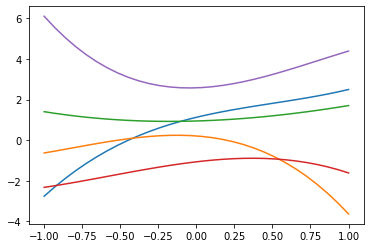

In [84]:
mu_0 = np.zeros(H)
Sigma_0 = np.identity(H)

BayesLR = BayesianLinearRigression()
BayesLR.set_prior(mu_0, Sigma_0, 1)

x_lin = np.linspace(-1, 1, 30).reshape(-1,1)

for i in range(5):
    y_sample = BayesLR.get_sample_from_posterior(x_lin)
    plt.plot(x_lin, y_sample)

学習データを用いて事後分布を計算し，そこから予測分布の平均と分散を可視化してみる

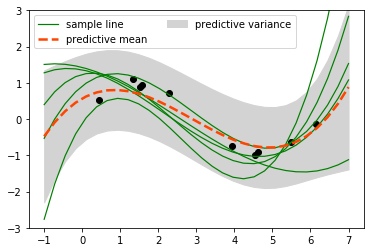

In [85]:
post_mu, post_Sigma = BayesLR.learn(x_train, y_train, 3)

x_lin = np.linspace(-1, 7, 30).reshape(-1,1)

pred_mean, pred_var = BayesLR.predict(x_lin)
upper = pred_mean + np.sqrt(pred_var)
lower = pred_mean - np.sqrt(pred_var)

for i in range(5):
    y_sample = BayesLR.get_sample_from_posterior(x_lin)
    if i==0:
        plt.plot(x_lin, y_sample, color='green', linewidth = 1.2, label='sample line')
    else:
        plt.plot(x_lin, y_sample, color='green', linewidth = 1.2)

plt.plot(x_lin, pred_mean, color='orangered', linewidth = 2.5, linestyle='dashed', label='predictive mean')
plt.fill_between(x_lin[:,0], upper, lower, color='lightgrey', label='predictive variance')
plt.scatter(x_train, y_train, color='black', marker='o')

plt.legend(ncol=2)
plt.ylim(-3,3)
plt.show()

一点ずつ学習させて，予測分布の挙動を見てみる．

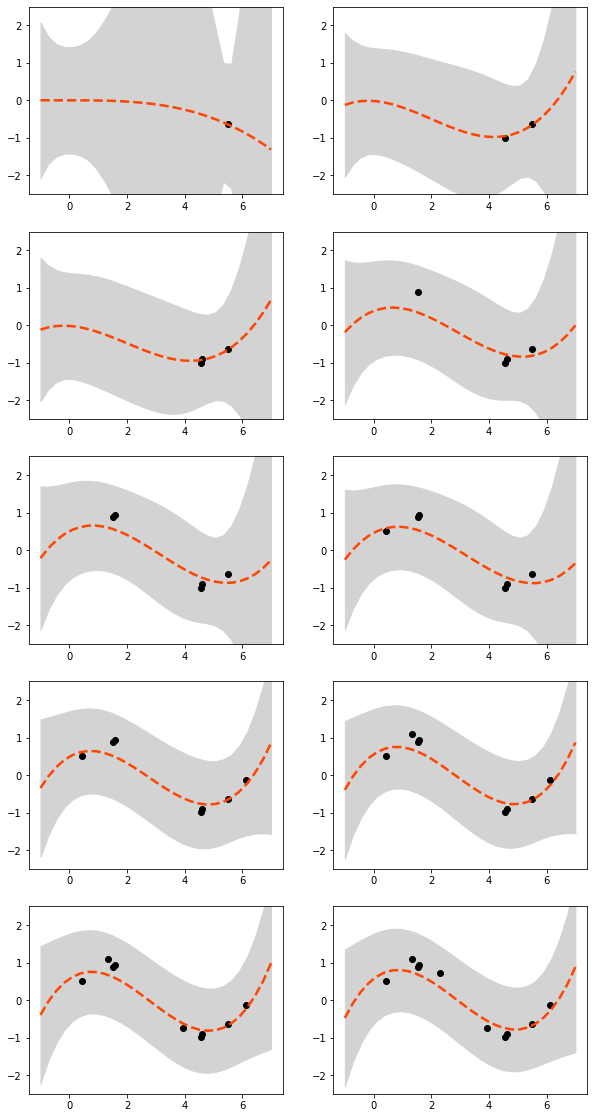

In [99]:
random_set = [1, 2, 3, 5, 7, 10]

mu_0 = np.zeros(H)
Sigma_0 = np.identity(H)

x_lin = np.linspace(-1, 7, 30).reshape(-1,1)

BayesLR = BayesianLinearRigression()
BayesLR.set_prior(mu_0, Sigma_0, 1)

plt.figure(figsize=(10,20))
for i in range(N_train):
    BayesLR.learn(x_train[i].reshape(-1,1), y_train[i].reshape(-1,1), 3)
    pred_mean, pred_var = BayesLR.predict(x_lin)
    upper = pred_mean + np.sqrt(pred_var)
    lower = pred_mean - np.sqrt(pred_var)
    plt.subplot(5,2,i+1)
    plt.plot(x_lin, pred_mean, color='orangered', linewidth = 2.5, linestyle='dashed', label='predictive mean')
    plt.fill_between(x_lin[:,0], upper, lower, color='lightgrey', label='predictive variance')
    plt.scatter(x_train[0:i+1], y_train[0:i+1], color='black', marker='o')
    plt.ylim(-2.5,2.5)
